## Google Drive login 

In [1]:
!pip install --upgrade gupload

from pydrive.auth import GoogleAuth
from google.colab import auth

# Authenticate and create the PyDrive client.
auth.authenticate_user()

Requirement already up-to-date: gupload in /usr/local/lib/python3.7/dist-packages (1.1.0)


# Regression

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

from sklearn.model_selection import KFold

np.random.seed(22)
torch.manual_seed(22)

## Dataset

In [3]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv 

--2021-06-09 14:58:57--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv.1’

train_data.csv.1    100%[===================>]   3.69K  --.-KB/s    in 0s      

2021-06-09 14:58:58 (87.6 MB/s) - ‘regression_dataset/train_data.csv.1’ saved [3776/3776]

--2021-06-09 14:58:58--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘r

## Select device

In [4]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


## Model definition

### Early stopping

In [5]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Neural network

In [6]:
class Net(nn.Module):

    def __init__(self, Ni, Nh1, Nh2, No, pDrop):
        super().__init__()
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2) 
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.sig = nn.Sigmoid()
        self.relu= nn.ReLU()
        self.drp = nn.Dropout(p=pDrop)
        print("Network initialized.")

    def forward(self, x, additional_out=False):
        x = self.relu(self.fc1(x))
        x = self.drp(x)
        x = self.relu(self.fc2(x))
        x = self.drp(x)
        x = self.out(x)
        return x 

    def train_net(self, train_loader, val_loader, loss_function, optimizer, num_epochs, device):
        train_loss_log = []
        val_loss_log = []
        # initialize the early_stopping object
        #early_stopping = EarlyStopping(patience=50, verbose=False)
        for epoch_num in range(num_epochs):
            print('------------------------------------------------------------')
            print(f'EPOCH {epoch_num}')
            # ....................... TRAIN .......................
            train_loss = []
            self.train() # Training mode (e.g. enable dropout)
            for sample_batched in train_loader:
                # Move data to device
                x = sample_batched[0].to(device)
                label = sample_batched[1].to(device)
                # Forward pass
                out = self.forward(x)
                # Compute loss
                loss = loss_function(out, label)
                # Backpropagation
                self.zero_grad()
                loss.backward()
                # Update the weights
                optimizer.step()
                # Save train loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                train_loss.append(loss_batch)
            # Save average train loss
            train_loss = np.mean(train_loss)
            print(f"Average train loss: {train_loss}")
            train_loss_log.append(train_loss)
            # .................... VALIDATION .....................
            val_loss= []
            self.eval() # Evaluation mode (e.g. disable dropout)
            with torch.no_grad(): # Disable gradient tracking
                for sample_batched in val_loader:
                    # Move data to device
                    x = sample_batched[0].to(device)
                    label = sample_batched[1].to(device)
                    # Forward pass
                    out = self.forward(x)
                    # Compute loss
                    loss = loss_function(out, label)
                    # Save val loss for this batch
                    loss_batch = loss.detach().cpu().numpy()
                    val_loss.append(loss_batch)
            # Save average validation loss
            val_loss = np.mean(val_loss)
            print(f"Average validation loss: {np.mean(val_loss)}")
            val_loss_log.append(val_loss)
            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            #early_stopping(val_loss, self)
            #if early_stopping.early_stop:
            #    print("Early stopping")
            #    break
        return train_loss_log, val_loss_log

    def save(self, path):
        # The state dictionary includes all the parameters of the network
        net_state_dict = self.state_dict()
        # Save the state dict to a file
        torch.save(net_state_dict, path)

    def load(self, path):
        # Load the state dict previously saved
        net_state_dict = torch.load(path)
        # Update the network parameters
        self.load_state_dict(net_state_dict)

    def test_net(self, test_loader, loss_function, device):
        test_loss = []
        self.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in test_loader:
                # Move data to device
                x = sample_batched[0].to(device)
                label = sample_batched[1][0].to(device)
                # Forward pass
                out = self.forward(x)
                # Compute loss
                loss = loss_function(out, label)
                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                test_loss.append(loss_batch)
        test_loss = np.mean(test_loss)
        return test_loss 

    def predict(self, loader, device):
        outputs = [] 
        self.eval()
        with torch.no_grad():
            for sample_batched in loader:
                x = sample_batched[0].to(device)
                out = self.forward(x) 
                out = out.detach().cpu().numpy()
                outputs.append(out)
        return outputs

## Dataset class

In [7]:
class CsvDataset(Dataset):

  def __init__(self, csv_file, transform=None):
    """
    Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform
    self.data = pd.read_csv(csv_file)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    input = self.data.iloc[idx]['input']
    label = self.data.iloc[idx]['label']
    sample = (input, label)
    if self.transform:
        sample = self.transform(sample)
    return sample

In [8]:
class ToTensor(object):
    """Convert sample to Tensors."""
    def __call__(self, sample):
        x, y = sample
        return (torch.Tensor([x]).float(),
                torch.Tensor([y]).float())

In [9]:
def plot_loss(train_loss_log, val_loss_log):
    plt.figure(figsize=(12, 7))
    plt.plot(train_loss_log, label='Train')
    plt.plot(val_loss_log, label='Validation')
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.tick_params(axis='both', labelsize=14)
    plt.legend(fontsize=18)
    plt.grid(linestyle='--')
    plt.savefig('loss.pdf', bbox_inches='tight')
    plt.show()

## Cross validation

In [10]:
def CrossValidation(config, dataset, device, k_fold=4, n_runs=3):
    """Cross validation function.
    Args:
        config (dict): hyperparameters dictionary
        dataset (Dataset): Dataset containing the data
        k_fold (int): number of folds for cross-validation 
    """
    par_log = []
    train_loss_log = []
    val_loss_log = []
    for i in range(n_runs):
        total_size = len(dataset)
        fraction = 1/k_fold
        seg = int(total_size * fraction)
        loss = nn.MSELoss()
        # tr:train, val:validation; r:right, l:left;  eg: trrr: right index of right side train subset 
        # index: [trll,trlr],[vall,valr],[trrl,trrr]
        for i in range(k_fold):
            trll = 0
            trlr = i * seg
            vall = trlr
            valr = i * seg + seg
            trrl = valr
            trrr = total_size
            #print("train indices: [%d,%d),[%d,%d), test indices: [%d,%d)" 
            #      % (trll,trlr,trrl,trrr,vall,valr))
            train_left_indices = list(range(trll, trlr))
            train_right_indices = list(range(trrl, trrr))
            train_indices = train_left_indices + train_right_indices
            val_indices = list(range(vall, valr))
            train_set = torch.utils.data.dataset.Subset(dataset, train_indices)
            val_set = torch.utils.data.dataset.Subset(dataset, val_indices)  
            train_loader = torch.utils.data.DataLoader(train_set, batch_size=10,
                                            shuffle=True, num_workers=2)
            val_loader = torch.utils.data.DataLoader(val_set, batch_size=10,
                                            shuffle=False, num_workers=2)
            # Take a random sample of parameters
            par_sample = {}
            for k in config.keys():
                par_sample[k] = np.random.choice(config[k])
            par_log.append(par_sample)
            # Initalize the model 
            Ni = 1
            Nh1 = par_sample['Nh']
            Nh2 = par_sample['Nh']*2
            No = 1
            pDrop = par_sample['Dropout']
            model = Net(Ni, Nh1, Nh2, No, pDrop).to(device)
            if par_sample['Optimizer'] == 'Adam':
                opt = optim.Adam(model.parameters(), lr=par_sample['Learning_rate'], 
                                weight_decay=par_sample['Regularization'])
            if par_sample['Optimizer'] == 'SGD':
                opt = optim.SGD(model.parameters(), lr=par_sample['Learning_rate'],
                                momentum=0.9, weight_decay=par_sample['Regularization'])
            train_loss, val_loss = model.train_net(train_loader, 
                                                   val_loader, 
                                                   loss, 
                                                   opt, 
                                                   par_sample['Epochs'], 
                                                   device)
            train_loss_log.append(train_loss)
            val_loss_log.append(val_loss)
    return par_log, train_loss_log, val_loss_log

In [11]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('/content/regression_dataset/train_data.csv', transform=composed_transform)

In [12]:
config = {
    'Epochs': [50, 100, 200, 400],
    'Optimizer': ['SGD', 'Adam'],
    'Regularization': [1e-4, 1e-5, 1e-6],
    'Learning_rate': [0.01, 0.001, 0.0001],
    'Dropout': [0.05, 0.1, 0.15, 0.2],
    'Nh': [16, 32, 64]
}

In [13]:
par_kfold, train_loss_kfold, val_loss_kfold = CrossValidation(config, train_dataset, device, k_fold=4, n_runs=10)

Streaming output truncated to the last 5000 lines.
Average train loss: 2.7427477836608887
Average validation loss: 1.5520540475845337
------------------------------------------------------------
EPOCH 52
Average train loss: 2.777869462966919
Average validation loss: 2.2617647647857666
------------------------------------------------------------
EPOCH 53
Average train loss: 2.525418519973755
Average validation loss: 2.025015354156494
------------------------------------------------------------
EPOCH 54
Average train loss: 2.797621726989746
Average validation loss: 2.202937364578247
------------------------------------------------------------
EPOCH 55
Average train loss: 2.52996826171875
Average validation loss: 2.373631477355957
------------------------------------------------------------
EPOCH 56
Average train loss: 2.542008876800537
Average validation loss: 1.780438780784607
------------------------------------------------------------
EPOCH 57
Average train loss: 2.2956833839416504
Av

In [14]:
val_final_losses = [v[-1] for v in val_loss_kfold]
best_par = par_kfold[np.argmin(val_final_losses)]
best_par

{'Dropout': 0.15,
 'Epochs': 400,
 'Learning_rate': 0.01,
 'Nh': 64,
 'Optimizer': 'Adam',
 'Regularization': 0.0001}

In [15]:
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=2)
val_loader = train_loader
Ni = 1
Nh1 = best_par['Nh']
Nh2 = best_par['Nh']*2
No = 1
pDrop = best_par['Dropout']
model = Net(Ni, Nh1, Nh2, No, pDrop).to(device)
opt = optim.Adam(model.parameters(), 
                 lr=best_par['Learning_rate'], 
                 weight_decay=best_par['Regularization'])
loss = nn.MSELoss()
train_loss, val_loss = model.train_net(train_loader, 
                                       val_loader, 
                                       loss, 
                                       opt, 
                                       best_par['Epochs'], 
                                       device)

Network initialized.
------------------------------------------------------------
EPOCH 0
Average train loss: 6.727243900299072
Average validation loss: 2.8875954151153564
------------------------------------------------------------
EPOCH 1
Average train loss: 3.34704852104187
Average validation loss: 2.9554038047790527
------------------------------------------------------------
EPOCH 2
Average train loss: 2.792076349258423
Average validation loss: 2.361971378326416
------------------------------------------------------------
EPOCH 3
Average train loss: 2.3963048458099365
Average validation loss: 1.9945542812347412
------------------------------------------------------------
EPOCH 4
Average train loss: 2.542496681213379
Average validation loss: 1.862830400466919
------------------------------------------------------------
EPOCH 5
Average train loss: 2.129110336303711
Average validation loss: 1.7983516454696655
------------------------------------------------------------
EPOCH 6
Averag

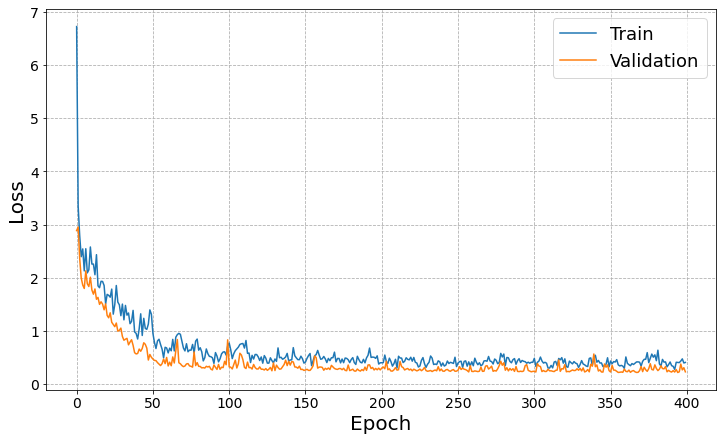

In [16]:
plot_loss(train_loss, val_loss)

### Save the network and the optimizer state

In [17]:
# Save the net
model.save('net_reg_parameters.torch')

In [18]:
# Save the optimizer state
torch.save(opt.state_dict(), 'optimizer_reg_state.torch')

## Model test

### Load the model 

In [19]:
#best_par = {
#    'Dropout': 0.2,
#    'Epochs': 200,
#    'Learning_rate': 0.001,
#    'Nh': 80,
#    'Optimizer': 'Adam',
#    'Regularization': 0.0001
#}

model = Net(Ni=1, 
            Nh1=best_par['Nh'], 
            Nh2=best_par['Nh']*2, 
            No=1, 
            pDrop=best_par['Dropout']).to(device)

model.load('net_reg_parameters.torch')

Network initialized.


### Compute accuracy on test set

In [20]:
composed_transform = transforms.Compose([ToTensor()])
test_dataset = CsvDataset('/content/regression_dataset/test_data.csv', 
                          transform=composed_transform)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=2)

In [21]:
loss_function = nn.MSELoss()
test_loss = model.test_net(test_loader, loss_function, device)
print('Test loss:', test_loss)

Test loss: 3.7134705


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### Test model prediction

In [22]:
x_vec = np.linspace(-5, 5, 1000).reshape(1000, 1)
lb = np.ones(1000).reshape(1000, 1)
x = np.hstack((x_vec, lb)).reshape(1000, 2)
x = pd.DataFrame(x, columns=['input', 'label'])
x.to_csv('pred_data.csv', index=False)

In [23]:
composed_transform = transforms.Compose([ToTensor()])
pred_dataset = CsvDataset('/content/pred_data.csv', 
                          transform=composed_transform)
pred_loader = DataLoader(pred_dataset, batch_size=20, shuffle=False, num_workers=2)

In [24]:
# Network output
y_vec = np.array(model.predict(pred_loader, device)).flatten()

In [25]:
tr_data = pd.read_csv("regression_dataset/train_data.csv")
ts_data = pd.read_csv("regression_dataset/test_data.csv")

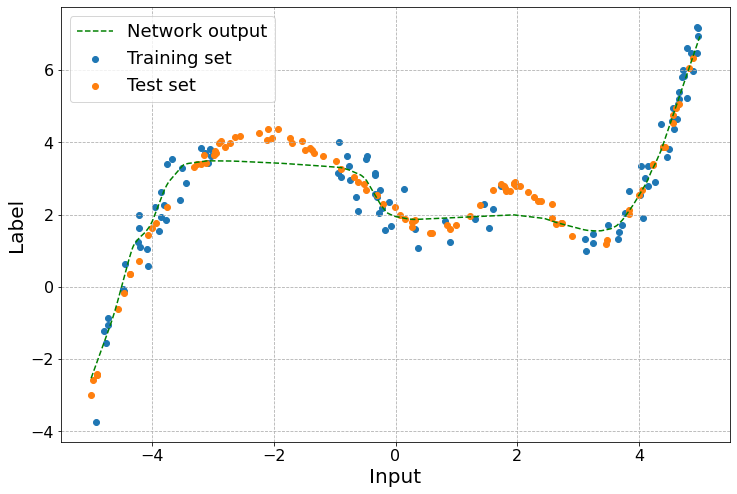

In [26]:
# Plot output
plt.figure(figsize=(12,8))
plt.plot(x['input'], y_vec, 'g--', label='Network output')
plt.scatter(tr_data['input'], tr_data['label'], label='Training set')
plt.scatter(ts_data['input'], ts_data['label'], label='Test set')
plt.xlabel('Input', fontsize=20)
plt.ylabel('Label', fontsize=20)
plt.grid(ls='--')
plt.legend(fontsize=18)
plt.tick_params(labelsize=16)
plt.savefig('reg_pred.pdf', bbox_inches='tight')
plt.show()

## Neural Network analysis

### Weights histograms

In [27]:
# First hidden layer
h1_w = model.fc1.weight.data.cpu().numpy() 
h1_b = model.fc1.bias.data.cpu().numpy() 

# Second hidden layer
h2_w = model.fc2.weight.data.cpu().numpy()
h2_b = model.fc2.bias.data.cpu().numpy() 

# Output layer
out_w = model.out.weight.data.cpu().numpy() 
out_b = model.out.bias.data.cpu().numpy() 

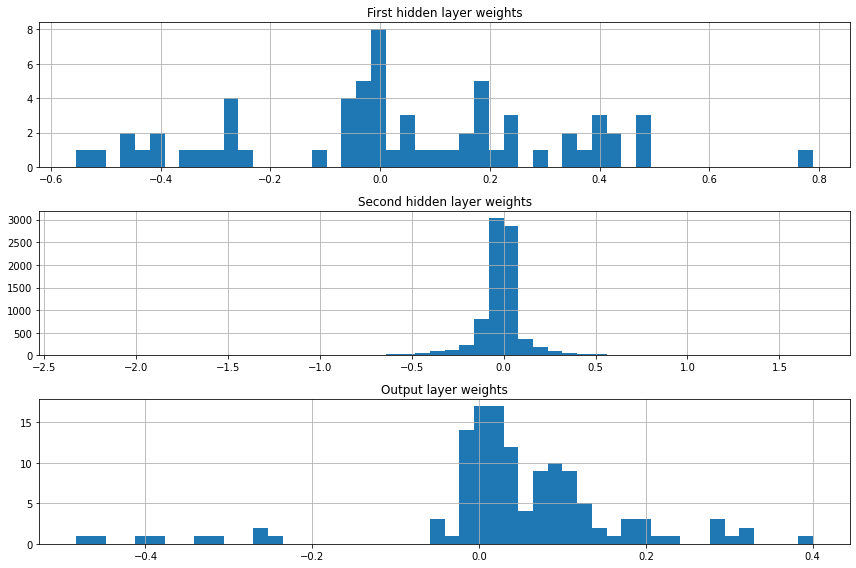

In [28]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.savefig('reg_weights_histo.pdf', bbox_inches='tight')
plt.show()

### Activations

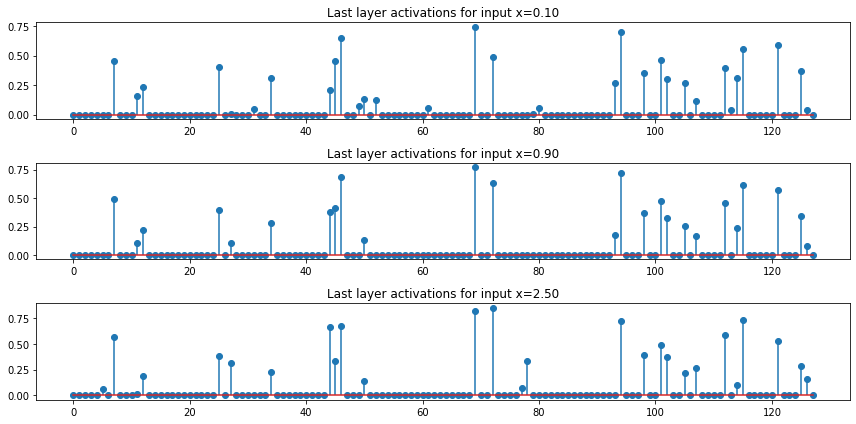

In [29]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output) 

### Register hook  
hook_handle = model.fc2.register_forward_hook(get_activation)

### Analyze activations
model = model.to(device)
model.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = model(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = model(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = model(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.savefig('reg_activations.pdf', bbox_inches='tight')
plt.show()

## Save files in Google Drive

In [30]:
!mkdir outs1
!mv checkpoint.pt loss.pdf net_reg_parameters.torch optimizer_reg_state.torch reg_activations.pdf reg_pred.pdf reg_weights_histo.pdf outs1

!gupload --to '1DIDzlTJFk4Ks4rWgCfvjq_Pm6kL6ADDX' outs1/*

Uploading file: outs1/checkpoint.pt as: checkpoint.pt
Uploading file: outs1/loss.pdf as: loss.pdf
Uploading file: outs1/net_reg_parameters.torch as: net_reg_parameters.torch
Uploading file: outs1/optimizer_reg_state.torch as: optimizer_reg_state.torch
Uploading file: outs1/reg_activations.pdf as: reg_activations.pdf
Uploading file: outs1/reg_pred.pdf as: reg_pred.pdf
Uploading file: outs1/reg_weights_histo.pdf as: reg_weights_histo.pdf
